In [15]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import LinearTriInterpolator, TriAnalyzer, Triangulation
from osgeo import gdal
from scipy.interpolate import griddata
import pandas as pd
from netCDF4 import Dataset
# imp


In [16]:
def estimate_grid_spacing(x,y, nsamples=100):
    import random
    import sys
    coords = list(set(zip(x,y)))
    if nsamples != len(x):
        points = [random.choice(coords) for i in range(nsamples)] # pick N random points
    else:
        points = coords
    MD = []
    for p0x, p0y in points:
        minimum_distance = sys.maxsize
        for px, py in coords:
            distance = np.sqrt((p0x - px) ** 2 + (p0y - py) ** 2)
            if (distance < minimum_distance) & (distance !=0):
                minimum_distance = distance
        MD.append(minimum_distance)
    dxdy = np.median(MD)
    return dxdy

def critical_shear_stress(D_meters, rhow=1024, nu=1e-6, s=2.65, g=9.81):
    # D_meters = grain size in meters, can be array
    # rhow = density of water in kg/m3
    # nu = kinematic viscosity of water
    # s = specific gravity of sediment
    # g = acceleratin due to gravity
    Dstar = ((g * (s-1))/ nu**2)**(1/3) * D_meters
    SHcr = (0.3/(1+1.2*Dstar)) + 0.055*(1-np.exp(-0.02 * Dstar))
    taucrit = rhow * (s - 1) * g * D_meters * SHcr #in Pascals
    return taucrit
    
def calc_receptor_taucrit_unstruct(receptor_filename, xc, yc, latlon=False):
    if ((receptor_filename is not None) or (not receptor_filename == "")):
        data = gdal.Open(receptor_filename)
        img = data.GetRasterBand(1)
        receptor_array = img.ReadAsArray()
        receptor_array[receptor_array < 0] = 0
        (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = data.GetGeoTransform()
        cols = data.RasterXSize
        rows = data.RasterYSize
        r_cols = np.linspace(np.nanmin(xc), np.nanmax(xc), cols)
        r_rows = np.linspace(np.nanmin(yc), np.nanmax(yc), rows)
        # r_rows = np.arange(rows) * y_size + upper_left_y + (y_size / 2)
        # r_cols = np.arange(cols) * x_size + upper_left_x + (x_size / 2)
        if latlon == True:
            r_cols = np.where(r_cols<0, r_cols+360, r_cols)
        x_grid, y_grid = np.meshgrid(r_cols, r_rows)
        receptor_array = griddata((x_grid.flatten(), y_grid.flatten()), receptor_array.flatten(), (xc,yc), method='nearest', fill_value=0)
        taucrit = critical_shear_stress(D_meters=receptor_array * 1e-6,
                            rhow=1024,
                            nu=1e-6,
                            s=2.65,
                            g=9.81) #units N/m2 = Pa
    else:
        # taucrit without a receptor
        #Assume the following grain sizes and conditions for typical beach sand (Nielsen, 1992 p.108)
        taucrit = critical_shear_stress(D_meters=200*1e-6, rhow=1024, nu=1e-6, s=2.65, g=9.81)  #units N/m2 = Pa
    return taucrit, receptor_array

def classify_mobility(mobility_parameter_dev, mobility_parameter_nodev):
    mobility_classification = np.zeros(mobility_parameter_dev.shape)
    #Reduced Erosion (Tw<Tb) & (Tw-Tb)>1
    mobility_classification = np.where(((mobility_parameter_dev < mobility_parameter_nodev) & (mobility_parameter_nodev>=1)), 1, mobility_classification)
    #Increased Erosion (Tw>Tb) & (Tw-Tb)>1
    mobility_classification = np.where(((mobility_parameter_dev > mobility_parameter_nodev) & (mobility_parameter_nodev>=1)), 2, mobility_classification)
    #Reduced Deposition (Tw>Tb) & (Tw-Tb)<1
    mobility_classification = np.where(((mobility_parameter_dev > mobility_parameter_nodev) & (mobility_parameter_nodev<1)), -1, mobility_classification)
    #Increased Deposition (Tw>Tb) & (Tw-Tb)>1
    mobility_classification = np.where(((mobility_parameter_dev < mobility_parameter_nodev) & (mobility_parameter_nodev<1)), -2, mobility_classification)
    #NoChange = 0
    return mobility_classification

def create_structured_array_from_unstructured(x, y, z, dxdy, flatness=0.2):
    # flatness is from 0-.5 .5 is equilateral triangle
    refx = np.arange(np.nanmin(x), np.nanmax(x)+dxdy, dxdy)
    refy = np.arange(np.nanmin(y), np.nanmax(y)+dxdy, dxdy)
    refxg, refyg = np.meshgrid(refx, refy)
    tri = Triangulation(x, y)
    mask = TriAnalyzer(tri).get_flat_tri_mask(flatness)
    tri.set_mask(mask)
    tli = LinearTriInterpolator(tri, z)
    z_interp = tli(refxg, refyg)
    return refxg, refyg, z_interp.data

In [17]:
fpath_nodev = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\tanana\tananaSingleTime\tanana_nodev"
fpath_dev = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\tanana\tananaSingleTime\tanana_dev_9"
receptor_filename = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\oregon\receptor\grainsize_receptor.tif"

In [18]:
# glob.glob(os.path.join(fpath_nodev, "*.nc")
files_nodev = [i for i in os.listdir(fpath_nodev) if i.endswith('.nc')]
files_dev = [i for i in os.listdir(fpath_dev) if i.endswith('.nc')]

In [19]:
ds = Dataset(os.path.join(fpath_nodev, files_nodev[0]))

In [20]:
list(ds.variables)

['mesh2d_enc_x',
 'mesh2d_enc_y',
 'mesh2d_enc_node_count',
 'mesh2d_enc_part_node_count',
 'mesh2d_enc_interior_ring',
 'mesh2d_enclosure_container',
 'Mesh2D',
 'NetNode_x',
 'NetNode_y',
 'projected_coordinate_system',
 'NetNode_z',
 'NetLink',
 'NetLinkType',
 'NetElemNode',
 'NetElemLink',
 'NetLinkContour_x',
 'NetLinkContour_y',
 'NetLink_xu',
 'NetLink_yu',
 'BndLink',
 'FlowElem_xcc',
 'FlowElem_ycc',
 'FlowElem_zcc',
 'FlowElem_bac',
 'FlowElem_xzw',
 'FlowElem_yzw',
 'FlowElemContour_x',
 'FlowElemContour_y',
 'FlowElem_bl',
 'ElemLink',
 'FlowLink',
 'FlowLinkType',
 'FlowLink_xu',
 'FlowLink_yu',
 'FlowLink_lonu',
 'FlowLink_latu',
 'time',
 'LayCoord_cc',
 'LayCoord_w',
 'timestep',
 's1',
 's0',
 'waterdepth',
 'numlimdt',
 'taus',
 'unorm',
 'u0',
 'q1',
 'viu',
 'diu',
 'ucx',
 'ucy',
 'ucz',
 'ucxa',
 'ucya',
 'rho',
 'turkin1',
 'vicwwu',
 'tureps1',
 'czs']

In [34]:
csv_receptor = r'H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\DEMO unstructured\recetpor_array_csv\velocity_receptor.csv'
A = pd.read_csv(csv_receptor, header=None, index_col=0)
A.to_numpy().item()

In [43]:
ds.variables['ucxa'].coordinates.split()

['FlowElem_xcc', 'FlowElem_ycc']

In [28]:
ds.variables['ucxa'].dimensions

('time', 'nFlowElem')

In [12]:
import xarray as xr
DS = xr.open_dataset(os.path.join(fpath_nodev, files_nodev[0]))
DS

<xarray.Dataset>
Dimensions:                      (nmesh2d_EnclosurePoints: 1177,
                                  nmesh2d_EnclosureInstance: 1,
                                  nmesh2d_EnclosureParts: 1, nNetNode: 22509,
                                  nNetLink: 44428, nNetLinkPts: 2,
                                  nNetElem: 21920, nNetElemMaxNode: 4,
                                  nNetLinkContourPts: 4, nBndLink: 1176,
                                  nFlowElem: 21920, nFlowElemContourPts: 4,
                                  nFlowLink: 43324, nFlowLinkPts: 2, time: 2,
                                  laydim: 20, wdim: 21)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2017-03-20 2017-03-20T...
Dimensions without coordinates: nmesh2d_EnclosurePoints,
                                nmesh2d_EnclosureInstance,
                                nmesh2d_EnclosureParts, nNetNode, nNetLink,
                                nNetLinkPts, nNetElem, nNetElemMaxNode,
                                nNetLinkContourPts, nBndLink, nFlowElem,
                                nFlowElemContourPts, nFlowLink, nFlowLinkPts,
                                laydim, wdim
Data variables: (12/53)
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    ...                           ...
    ucya                         (time, nFlowElem) float64 ...
    rho                          (time, nFlowElem, laydim) float64 ...
    turkin1                      (time, nFlowLink, wdim) float64 ...
    vicwwu                       (time, nFlowLink, wdim) float64 ...
    tureps1                      (time, nFlowLink, wdim) float64 ...
    czs                          (time, nFlowElem) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.26.63858M, Jun 27 2019, 1...
    history:        Created on 2021-11-14T10:18:22-0700, D-Flow FM
    date_created:   2021-11-14T10:18:22-0700
    date_modified:  2021-11-14T10:18:22-0700
    Conventions:    UGRID-0.9

In [11]:
list(ds.attributes)

AttributeError: NetCDF: Attribute not found

In [24]:
#extract return order from file name, file must be in format x_xxx_returninverval_xxx.nc, example: 1_tanana_1_map.nc
return_intervals_nodev = np.zeros((len(files_nodev)))
for ic, file in enumerate(files_nodev):
    return_intervals_nodev[ic] = float(file.split('.')[0].split('_')[2])
return_intervals_dev = np.zeros((len(files_dev)))
for ic, file in enumerate(files_dev):
    return_intervals_dev[ic] = float(file.split('.')[0].split('_')[2])

#ensure return order for nodev matches dev files
if np.any(return_intervals_nodev != return_intervals_dev):
    adjust_dev_order = []
    for ri in return_intervals_dev:
        adjust_dev_order = np.append(adjust_dev_order, np.flatnonzero(return_intervals_dev == ri))
    adjust_dev_order
    files_dev = [files_dev[int(i)] for i in adjust_dev_order]
    return_intervals_dev = [return_intervals_dev[int(i)] for i in adjust_dev_order]

DF = pd.DataFrame({'files_nodev':files_nodev, 
                   'return_intervals_nodev':return_intervals_nodev,
                   'files_dev':files_dev,
                   'return_intervals_dev':return_intervals_dev})

In [25]:
first_run = True
for ir, row in DF.iterrows():
    # DS_nodev = xr.open_dataset(os.path.join(fpath_nodev, row.files_nodev))
    DS_nodev = Dataset(os.path.join(fpath_nodev, row.files_nodev))
    # DS_dev = xr.open_dataset(os.path.join(fpath_dev, row.files_dev))
    DS_dev = Dataset(os.path.join(fpath_dev, row.files_dev))
    tau_nodev = DS_nodev.variables["taus"][-1,:].data
    tau_dev = DS_dev.variables["taus"][-1,:].data

    if first_run:
        xc = DS_nodev.variables["FlowElem_xcc"][:].data
        yc = DS_nodev.variables["FlowElem_ycc"][:].data
        taumax_combined_nodev = 1/row.return_intervals_nodev * tau_nodev 
        taumax_combined_dev = 1/row.return_intervals_dev * tau_dev 
        first_run = False
        
    # DS_dev.close()
    # DS_nodev.close()
    taumax_combined_nodev = taumax_combined_nodev + 1/row.return_intervals_nodev * tau_nodev 
    taumax_combined_dev = taumax_combined_dev + 1/row.return_intervals_dev * tau_dev 

#calculate stressor diff
tau_diff = taumax_combined_dev - taumax_combined_nodev

#calculate mobility diff
taucrit, receptor_array = calc_receptor_taucrit_unstruct(receptor_filename, xc, yc)
mobility_parameter_nodev = taumax_combined_nodev / taucrit
mobility_parameter_dev = taumax_combined_dev / taucrit
mobility_parameter_diff = mobility_parameter_dev - mobility_parameter_nodev

#create structured output from the unstructured input
dxdy = estimate_grid_spacing(xc,yc, nsamples=100)
rx, ry, tau_diff_struct = create_structured_array_from_unstructured(xc, yc, tau_diff, dxdy, flatness=0.2)
_, _, mobility_parameter_nodev_struct = create_structured_array_from_unstructured(xc, yc, mobility_parameter_nodev, dxdy, flatness=0.2)
_, _, mobility_parameter_dev_struct = create_structured_array_from_unstructured(xc, yc, mobility_parameter_dev, dxdy, flatness=0.2)
_, _, mobility_parameter_diff_struct = create_structured_array_from_unstructured(xc, yc, mobility_parameter_diff, dxdy, flatness=0.2)
_, _, receptor_array_struct = create_structured_array_from_unstructured(xc, yc, receptor_array, dxdy, flatness=0.2)

mobility_classification = classify_mobility(mobility_parameter_dev, mobility_parameter_nodev)

listOfFiles = [mobility_parameter_nodev_struct, mobility_parameter_dev_struct, mobility_parameter_diff_struct, tau_diff_struct, mobility_classification]

# return listOfFiles, rx, ry, dxdy

C:\Users\local_tnelson76\Temp\ipykernel_11964\3330056011.py:27: RuntimeWarning: divide by zero encountered in divide
  mobility_parameter_nodev = taumax_combined_nodev / taucrit
C:\Users\local_tnelson76\Temp\ipykernel_11964\3330056011.py:28: RuntimeWarning: divide by zero encountered in divide
  mobility_parameter_dev = taumax_combined_dev / taucrit
C:\Users\local_tnelson76\Temp\ipykernel_11964\3330056011.py:29: RuntimeWarning: invalid value encountered in subtract
  mobility_parameter_diff = mobility_parameter_dev - mobility_parameter_nodev
c:\Users\tnelson76\.conda\envs\C3507_SAM_HAB\lib\site-packages\matplotlib\tri\triinterpolate.py:277: RuntimeWarning: invalid value encountered in add
  return (self._plane_coefficients[tri_index, 0]*x +


In [26]:
DS_dev.variables.keys()

dict_keys(['mesh2d_enc_x', 'mesh2d_enc_y', 'mesh2d_enc_node_count', 'mesh2d_enc_part_node_count', 'mesh2d_enc_interior_ring', 'mesh2d_enclosure_container', 'Mesh2D', 'NetNode_x', 'NetNode_y', 'projected_coordinate_system', 'NetNode_z', 'NetLink', 'NetLinkType', 'NetElemNode', 'NetElemLink', 'NetLinkContour_x', 'NetLinkContour_y', 'NetLink_xu', 'NetLink_yu', 'BndLink', 'FlowElem_xcc', 'FlowElem_ycc', 'FlowElem_zcc', 'FlowElem_bac', 'FlowElem_xzw', 'FlowElem_yzw', 'FlowElemContour_x', 'FlowElemContour_y', 'FlowElem_bl', 'ElemLink', 'FlowLink', 'FlowLinkType', 'FlowLink_xu', 'FlowLink_yu', 'FlowLink_lonu', 'FlowLink_latu', 'time', 'LayCoord_cc', 'LayCoord_w', 'timestep', 's1', 's0', 'waterdepth', 'numlimdt', 'taus', 'unorm', 'u0', 'q1', 'viu', 'diu', 'ucx', 'ucy', 'ucz', 'ucxa', 'ucya', 'rho', 'turkin1', 'vicwwu', 'tureps1', 'czs'])

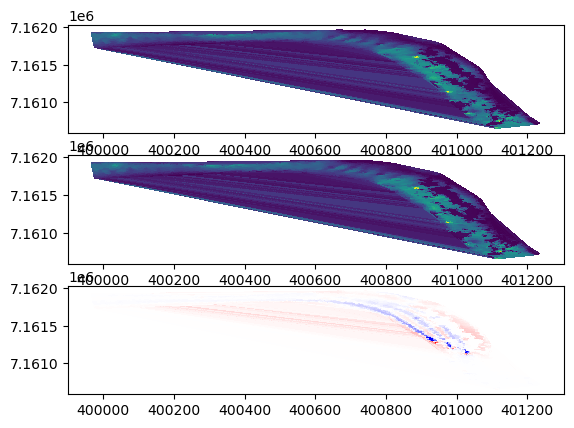

In [12]:
fig,ax = plt.subplots(nrows=3)
h0 = ax[0].tripcolor(xc, yc, mobility_parameter_nodev, shading='flat')
h1 = ax[1].tripcolor(xc, yc, mobility_parameter_dev, shading='flat')
h2 = ax[2].tripcolor(xc, yc, mobility_parameter_diff, shading='flat', vmin=-1, vmax=1, cmap='bwr')


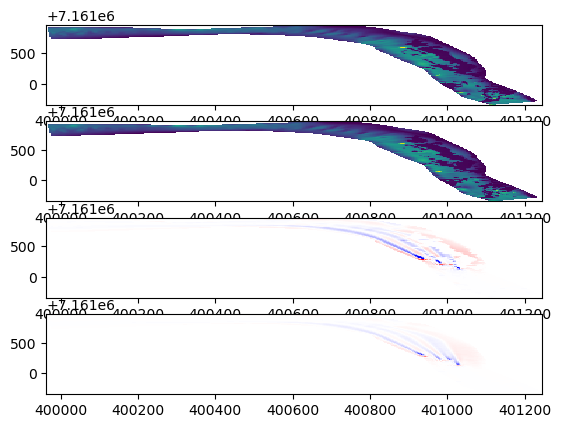

In [18]:
fig,ax = plt.subplots(nrows=4)
ax[0].pcolormesh(rx, ry, mobility_parameter_nodev_struct)
ax[1].pcolormesh(rx, ry, mobility_parameter_dev_struct)
ax[2].pcolormesh(rx, ry, mobility_parameter_diff_struct, vmin=-1, vmax=1, cmap='bwr')
ax[3].pcolormesh(rx, ry, tau_diff_struct, vmin=-0.5, vmax=0.5, cmap='bwr')

In [ ]:
# # listOfFiles, rx, ry, dxdy
# cell_resolution = [dxdy, dxdy]
# bounds = [rx.min() - dxdy/2, ry.max() + dxdy/2]
# array2 = np.flip(np.transpose(receptor_array_struct), axis=0)
# rows, cols = array2.shape

# output_raster = create_raster(
#     r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\tanana\tananaSingleTime\receptor_array_geotiff\grain_size_fake.tif",
#     cols,
#     rows,
#     nbands=1,
# )

# # post processing of numpy array to output raster
# numpy_array_to_raster(
#     output_raster,
#     array2,
#     bounds,
#     cell_resolution,
#     SPATIAL_REFERENCE_SYSTEM_WKID,
#     r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\tanana\tananaSingleTime\receptor_array_geotiff\grain_size_fake.tif",
# )